# scGPT Reference mapping

We performed analysis following three scenarions:
1. **scGPT reference mapping <--- YOU ARE HERE**
2. scGPT finetuned with GSE242423 dataset
3. standard method
    1. standard method with celltypist only
    2. with celltypist + scANVI

# Description
- we performed cell type annotation prediction using the labels from GSE242423:
    - Extreme OSK (xOSK)    
    - Fibroblast            
    - Fibroblast-like      
    - High OSK (hOSK)        
    - Intermediate         
    - Keratinocyte-like     
    - Partial                
    - Pre-iPSC              
    - iPSC

# Objective
- In this jupyter notebook we only perform cell type annotation using scGPT reference mapping on the validation dataset, which contains 30% of the GSE242423.
- We calculate evaluation metrics (NMI, ARI, Accuracy, Confusion matrix) using SKLEARN.

# Reference mapping with custom reprogramming dataset

In [3]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import sklearn
import warnings
import anndata
sys.path.insert(0, "../")
import scgpt as scg
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, accuracy_score, normalized_mutual_info_score

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
# Basic functions that needs to be reused
# SOX2 SOX2 SOX2  ---- SOX2.1 SOX2.2 SOX2.3 

def use_gene_names_as_var_index(query_adata):
    query_adata.var['gene_name'] = query_adata.var['gene_name'].astype(str)
    query_adata.var_names = query_adata.var['gene_name']
    #query_adata.obs['celltype'] = test_adata.obs['cell_line']
    # # optional step to visualize the dataset
    # Check if var_names are unique
    # Function to make gene names unique
    def make_unique(gene_names):
        name_count = {}
        unique_names = []
        
        for name in gene_names:
            if name in name_count:
                name_count[name] += 1
                unique_names.append(f"{name}.{name_count[name]}")
            else:
                name_count[name] = 0
                unique_names.append(name)
        
        return pd.Index(unique_names)
    
    # Apply the function to make var_names unique
    query_adata.var_names = make_unique(query_adata.var_names)
    return query_adata


# model configs

In [13]:
model_dir = Path("../../scGPT_human")

# Load your data (assuming it's in AnnData format)
ref_adata = sc.read_h5ad("../../REPROGRAMMING_DATASETS/RAW_labeled_reprogramming_reference_data.h5ad")
query_adata = sc.read_h5ad("../../REPROGRAMMING_DATASETS/GSE100344_NO_PROCESSED.h5ad")


# filtering genes
sc.pp.filter_genes(ref_adata, min_cells = 10)
#sc.pp.normalize_total(ref_adata, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
#sc.pp.log1p(ref_adata)

# filtering genes
sc.pp.filter_genes(query_adata, min_cells = 10)
#sc.pp.normalize_total(query_adata, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
#sc.pp.log1p(query_adata)

query_adata.obs['celltype'] = 'Unknown'
ref_adata.obs['treatment'] = ref_adata.obs['sample']
cell_type_key = "celltype"
obs_to_save = ['celltype','treatment']
gene_col = "index"

In [28]:
ref_adata.obs['treatment'] = ref_adata.obs['sample']
obs_to_save = ['celltype','treatment']


In [14]:
query_adata = use_gene_names_as_var_index(query_adata)

In [15]:
query_adata.var_names

Index(['PEX10', 'PEX14', 'SPSB1', 'RPL22P3', 'NMNAT1', 'TMEM51', 'FBXO42',
       'ALDH4A1', 'RER1', 'PANK4',
       ...
       'TRNE', 'CYTB', 'TRNT', 'TRNP', 'LOC389831', 'Unknown.1531',
       'Unknown.1532', 'Unknown.1533', 'LOC124905564', 'LOC124905573'],
      dtype='object', length=17590)

# reference dataset embeddings and visualization

scGPT - INFO - match 19244/25039 genes in vocabulary of size 60697.


/home/ubuntu/miniconda3/envs/new_scgpt_final/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Embedding cells: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 928/928 [01:11<00:00, 12.99it/s]


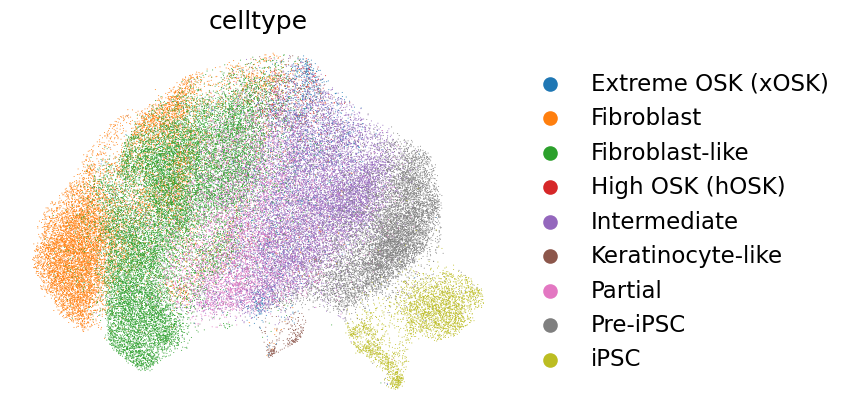

In [29]:
ref_embed_adata = scg.tasks.embed_data(
    ref_adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=obs_to_save,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)
# Optional step to visualize the reference dataset using the embeddings
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [31]:
ref_embed_adata.obs

,celltype,treatment
0,Fibroblast,D0
1,Fibroblast,D0
2,Fibroblast,D0
3,Fibroblast,D0
4,Fibroblast,D0
...,...,...
59373,iPSC,iPSC
59374,iPSC,iPSC
59375,iPSC,iPSC
59376,iPSC,iPSC


# Query dataset embeddings

In [32]:
query_adata.var

,gene_name,n_cells,index,id_in_vocab
PEX10,PEX10,53,PEX10,19357
PEX14,PEX14,125,PEX14,19363
SPSB1,SPSB1,86,SPSB1,32280
RPL22P3,RPL22P3,10,RPL22P3,44218
NMNAT1,NMNAT1,142,NMNAT1,17849
...,...,...,...,...
Unknown.1531,Unknown,130,Unknown.1531,-1
Unknown.1532,Unknown,92,Unknown.1532,-1
Unknown.1533,Unknown,72,Unknown.1533,-1
LOC124905564,LOC124905564,136,LOC124905564,-1


scGPT - INFO - match 15190/17590 genes in vocabulary of size 60697.


/home/ubuntu/miniconda3/envs/new_scgpt_final/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Embedding cells: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.10it/s]


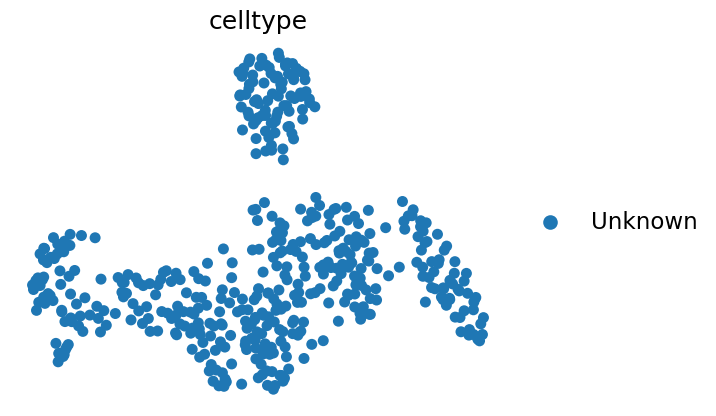

In [33]:
#test_adata = sc.read_h5ad("anndata/GSE100344.h5ad")
#test_adata.var['gene_name'] = test_adata.var['gene_name'].astype(str)
#test_adata.var_names = test_adata.var['gene_name']
#test_adata.obs['celltype'] = test_adata.obs['cell_line']
test_embed_adata = scg.tasks.embed_data(
    query_adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=obs_to_save,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)
# # optional step to visualize the dataset
sc.pp.neighbors(test_embed_adata, use_rep="X")
sc.tl.umap(test_embed_adata)
sc.pl.umap(test_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [34]:
test_embed_adata.obs

,celltype,treatment
SRR5739552,Unknown,Day_0
SRR5739553,Unknown,Day_0
SRR5739554,Unknown,Day_0
SRR5739555,Unknown,Day_0
SRR5739556,Unknown,Day_0
...,...,...
SRR5740027,Unknown,Day_16-
SRR5740028,Unknown,Day_16-
SRR5740029,Unknown,Day_16-
SRR5740030,Unknown,Day_16-


# propagating embeddings to query dataset

scGPT - INFO - match 15190/17590 genes in vocabulary of size 60697.


/home/ubuntu/miniconda3/envs/new_scgpt_final/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Embedding cells: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.84it/s]


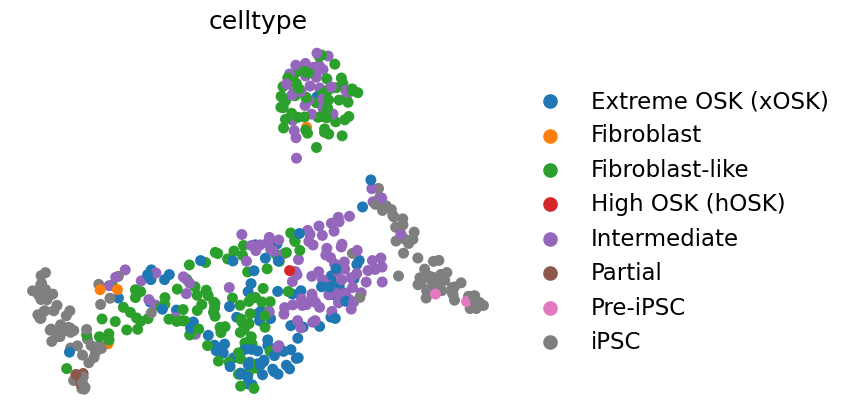

In [38]:
ref_cell_embeddings = ref_embed_adata.X
test_emebd = test_embed_adata.X

k = 10  # number of neighbors

if faiss_imported:
    # Declaring index, using most of the default parameters from
    index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
    index.add(ref_cell_embeddings)

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
#gt = val_adata.obs['celltype_gt'].to_numpy()
#accuracy_metric = sklearn.metrics.accuracy_score(gt, preds)

annotated_test_embed_adata = scg.tasks.embed_data(
    query_adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=['celltype','treatment'],  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

annotated_test_embed_adata.obs[cell_type_key] = preds
sc.pp.neighbors(annotated_test_embed_adata, use_rep="X")
sc.tl.umap(annotated_test_embed_adata)
sc.pl.umap(annotated_test_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [41]:
annotated_test_embed_adata.obs.groupby('treatment').size()

treatment
Day_0      96
Day_2      96
Day_8      96
Day_16+    96
Day_16-    96
dtype: int64

In [39]:
annotated_test_embed_adata.obsm['X_scGPT'] = annotated_test_embed_adata.X

In [53]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_umap_cell_types_by_timepoint(adata, output_file='umap_cell_types_comparison.png'):
    # Ensure UMAP coordinates are computed
    if 'X_umap' not in adata.obsm:
        sc.pp.neighbors(adata, use_rep="X")
        sc.tl.umap(adata)

    # Specify the desired order of time points
    desired_order = ['Day_0', 'Day_2', 'Day_8', 'Day_16+', 'Day_16-']
    
    # Filter and sort time points based on the desired order
    time_points = [tp for tp in desired_order if tp in adata.obs['treatment'].unique()]
    n_time_points = len(time_points)

    # Create a single column of subplots
    fig, axes = plt.subplots(n_time_points, 1, figsize=(12, 7*n_time_points), squeeze=False)
    
    # Flatten the axes array
    axes = axes.flatten()

    # Get unique cell types from 'celltype'
    all_cell_types = set(adata.obs['celltype'].unique())

    # Create a color map
    n_colors = len(all_cell_types)
    color_map = plt.cm.get_cmap('tab20')  # You can change this to any colormap you prefer
    colors = [mcolors.rgb2hex(color_map(i)) for i in range(n_colors)]
    color_dict = dict(zip(all_cell_types, colors))

    # Plot UMAP for each time point
    for i, time_point in enumerate(time_points):
        time_point_data = adata[adata.obs['treatment'] == time_point]
        
        ax = axes[i]
        sc.pl.umap(time_point_data, color='celltype', palette=color_dict, frameon=True, show=False, size=50, ax=ax, title=f"{time_point} - Predicted")
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        
        # Add a frame around the subplot
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

    # Remove any unused subplots
    for i in range(n_time_points, len(axes)):
        fig.delaxes(axes[i])

    # Add a main title
    fig.suptitle("UMAP Plots of Predicted Cell Types by Time Point", fontsize=16)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.98)  # Adjust for main title
    #plt.show()
    # Save the figure
    plt.savefig('umap/umap_cell_types_comparison_GSE100344_NO_PROCESSED.png', dpi=300, bbox_inches='tight')
    print(f"UMAP plot saved as {output_file}")

    # Close the figure to free up memory
    plt.close(fig)

# Usage
plot_umap_cell_types_by_timepoint(annotated_test_embed_adata, 'umap_cell_types_comparison_GSE100344_NO_PROCESSED.png')

/tmp/ipykernel_28736/2354604533.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20')  # You can change this to any colormap you prefer
/home/ubuntu/miniconda3/envs/new_scgpt_final/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/home/ubuntu/miniconda3/envs/new_scgpt_final/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/home/ubuntu/miniconda3/envs/new_scgpt_final/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: T

UMAP plot saved as umap_cell_types_comparison_GSE100344_NO_PROCESSED.png


# METRICS EVALUATION

## CONFUSION MATRIX

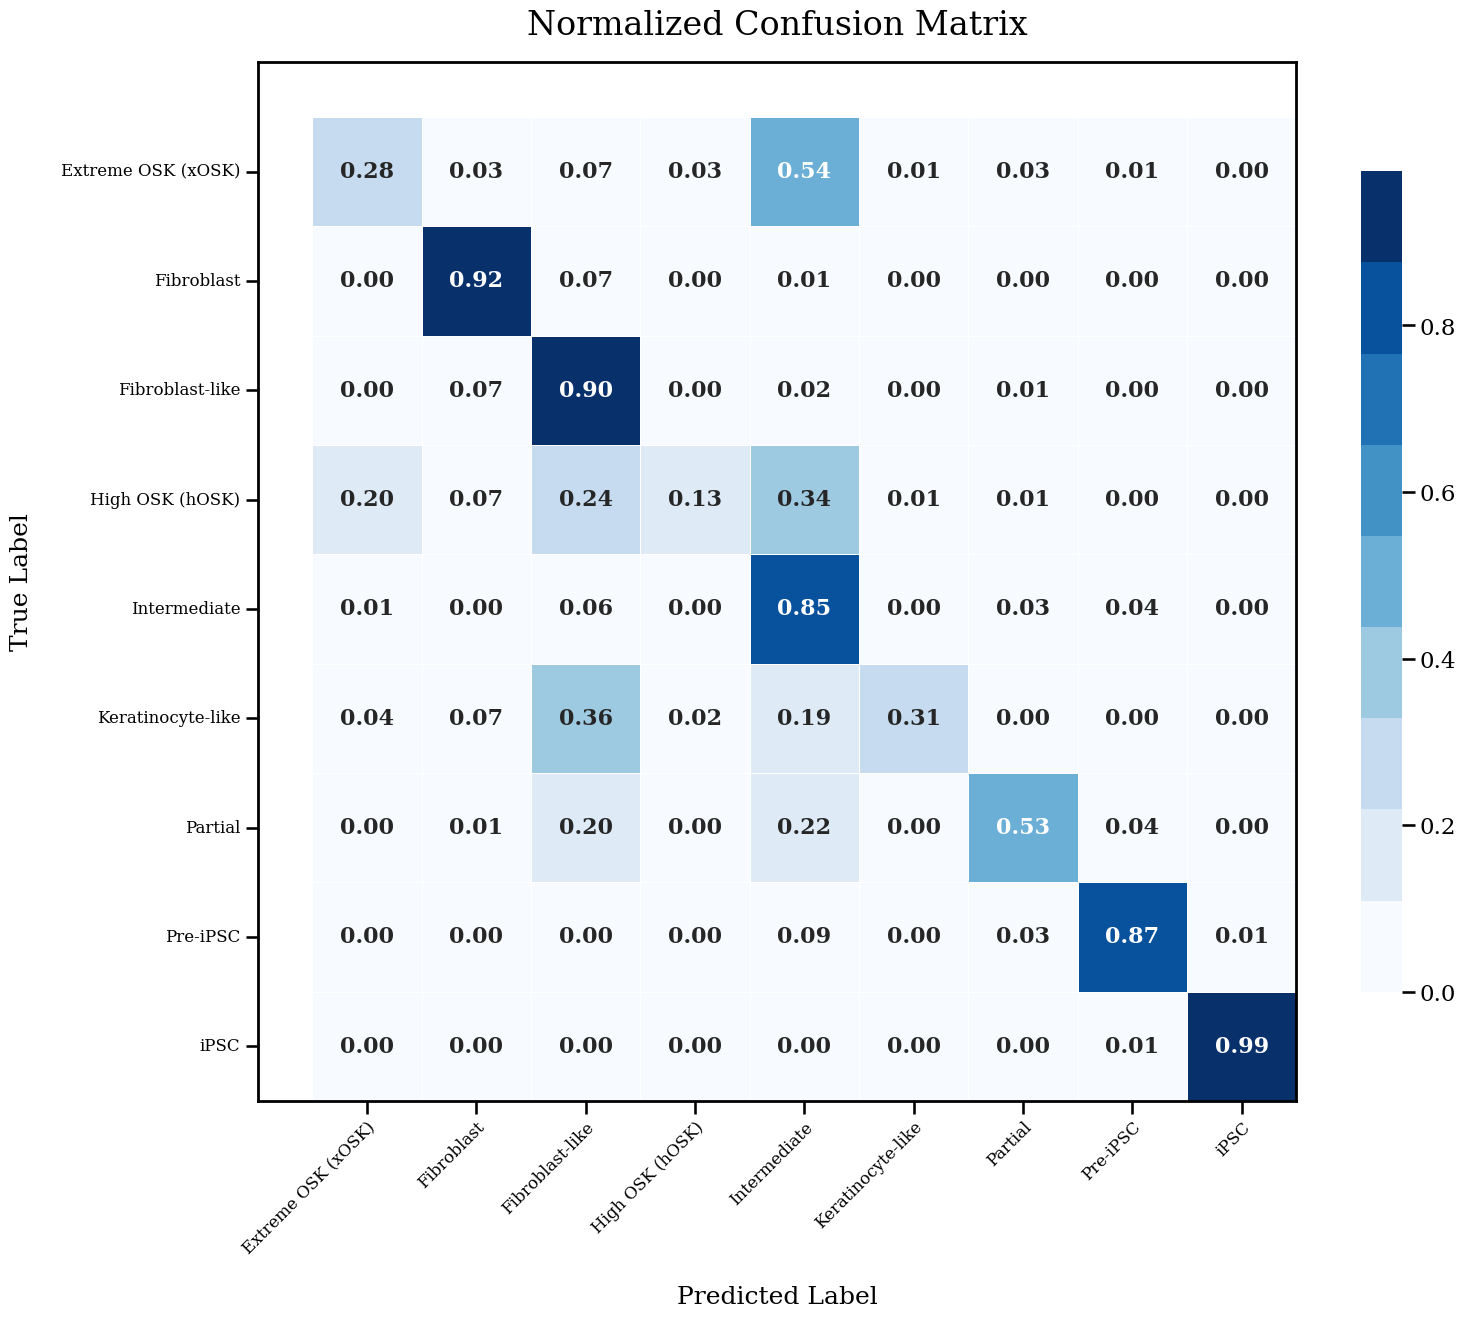

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def plot_aesthetic_normalized_confusion_matrix(y_true, y_pred):
    # Ensure labels are encoded as integers
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred_encoded = le.transform(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred_encoded)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Set up the matplotlib figure
    plt.figure(figsize=(16, 14))

    # Create a custom colormap
    colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
    cmap = sns.color_palette(colors, as_cmap=True)

    # Plot the heatmap
    ax = sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cmap, 
                     square=True, linewidths=0.5, cbar_kws={"shrink": .7},
                     annot_kws={'size': 16, 'weight': 'bold'}, 
                     xticklabels=le.classes_, yticklabels=le.classes_)

    # Improve the aesthetics
    plt.title('Normalized Confusion Matrix', fontsize=24, pad=20)
    plt.ylabel('True Label', fontsize=18, labelpad=20)
    plt.xlabel('Predicted Label', fontsize=18, labelpad=20)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0)

    # Increase tick label font size
    ax.tick_params(labelsize=12)

    # Add a border to the heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)

    # Use serif fonts for a more traditional scientific look
    plt.rcParams['font.family'] = 'serif'

    # Add gridlines
    ax.set_xticks(np.arange(cm_normalized.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm_normalized.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    plt.savefig('aesthetic_normalized_confusion_matrix.png', dpi=300, bbox_inches='tight')
    
    # Display the plot (optional, remove if you don't want to show it immediately)
    plt.show()
    
    # Close the plot to free up memory
    plt.close()

# Assuming 'gt' contains ground truth labels and 'preds' contains predicted labels
# Plot the aesthetic normalized confusion matrix
plot_aesthetic_normalized_confusion_matrix(annotated_test_embed_adata.obs['celltype_gt'], annotated_test_embed_adata.obs['celltype'])

In [66]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, accuracy_score, f1_score

def calculate_metrics(adata, true_label_key, pred_key):
    # Get true labels and predictions
    true_labels = adata.obs[true_label_key]
    pred_labels = adata.obs[pred_key]

    # Calculate ARI
    ari = adjusted_rand_score(true_labels, pred_labels)

    # Calculate NMI
    nmi = normalized_mutual_info_score(true_labels, pred_labels)

    X = adata.obsm['X_scGPT']

    # Calculate ASW
    asw = silhouette_score(X, pred_labels)
    asw_batch = silhouette_score(X, adata.obs['sample'])
    accuracy = accuracy_score(adata.obs[true_label_key], adata.obs[pred_key])
    f1 = f1_score(adata.obs[true_label_key], adata.obs[pred_key], average='weighted')
    return {
        'ARI': ari,
        'NMI': nmi,
        'ASW_LABEL': asw,
        'ASW_BATCH': asw_batch,
        'accuracy': accuracy,
        'F1_SCORE': f1
    }

# Assuming you have your validation data in val_adata
# and you've added predictions to val_adata.obs[pred_key]

true_label_key = 'celltype_gt'  # adjust this to match your true label column name
pred_key = 'celltype'  # adjust this to match your prediction column name

# Make sure predictions are in val_adata.obs[pred_key]
# If not, add them like this:
# val_adata.obs[pred_key] = preds

# Calculate metrics
metrics = calculate_metrics(annotated_test_embed_adata, true_label_key, pred_key)

# Print results
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


ARI: 0.6755
NMI: 0.6538
ASW_LABEL: 0.0239
ASW_BATCH: -0.0021
accuracy: 0.8313
F1_SCORE: 0.8221


In [44]:
# ONLY ASW BATCH
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, accuracy_score, f1_score

asw_batch = silhouette_score(annotated_test_embed_adata.X, annotated_test_embed_adata.obs['treatment'])
print("ASW_BATCH: ", asw_batch)

ASW_BATCH:  0.10048706


In [45]:
annotated_test_embed_adata.obs.groupby('celltype').size()

celltype
Extreme OSK (xOSK)     85
Fibroblast              4
Fibroblast-like       147
High OSK (hOSK)         1
Intermediate          127
Partial                 3
Pre-iPSC                2
iPSC                  111
dtype: int64

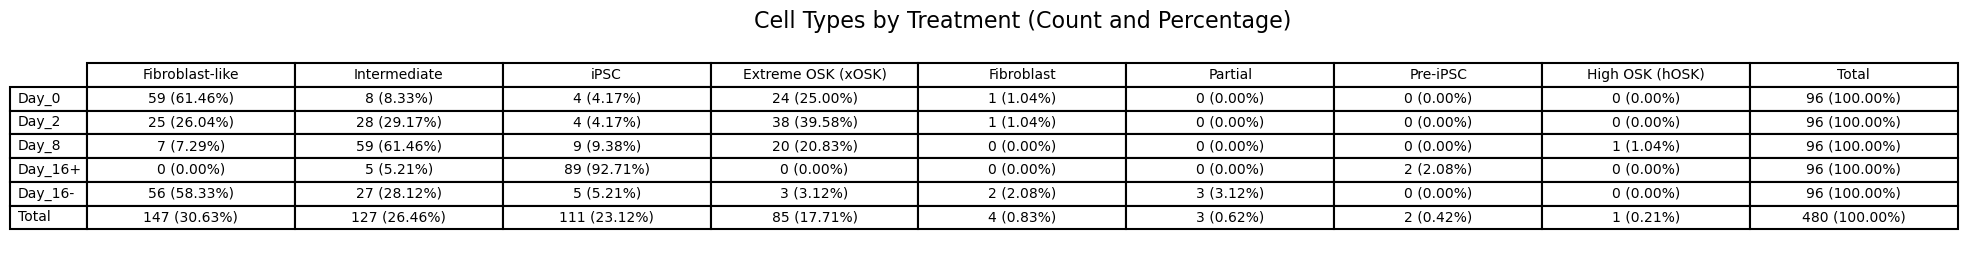

celltype  Fibroblast-like  Intermediate          iPSC Extreme OSK (xOSK)  \
treatment                                                                  
Day_0         59 (61.46%)     8 (8.33%)     4 (4.17%)        24 (25.00%)   
Day_2         25 (26.04%)   28 (29.17%)     4 (4.17%)        38 (39.58%)   
Day_8           7 (7.29%)   59 (61.46%)     9 (9.38%)        20 (20.83%)   
Day_16+         0 (0.00%)     5 (5.21%)   89 (92.71%)          0 (0.00%)   
Day_16-       56 (58.33%)   27 (28.12%)     5 (5.21%)          3 (3.12%)   
Total        147 (30.63%)  127 (26.46%)  111 (23.12%)        85 (17.71%)   

celltype  Fibroblast    Partial   Pre-iPSC High OSK (hOSK)          Total  
treatment                                                                  
Day_0      1 (1.04%)  0 (0.00%)  0 (0.00%)       0 (0.00%)   96 (100.00%)  
Day_2      1 (1.04%)  0 (0.00%)  0 (0.00%)       0 (0.00%)   96 (100.00%)  
Day_8      0 (0.00%)  0 (0.00%)  0 (0.00%)       1 (1.04%)   96 (100.00%)  
Day_16+    

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_celltype_by_treatment(adata):
    # Group by treatment and celltype
    summary = adata.obs.groupby(['treatment', 'celltype']).size().unstack(fill_value=0)
    
    # Add a total column
    summary['Total'] = summary.sum(axis=1)
    
    # Add a row for totals
    summary.loc['Total'] = summary.sum()
    
    # Sort columns by total count (excluding the 'Total' column)
    sorted_columns = summary.iloc[:-1, :-1].sum().sort_values(ascending=False).index
    summary = summary[list(sorted_columns) + ['Total']]
    
    # Calculate percentages
    summary_percentage = summary.div(summary['Total'], axis=0) * 100
    
    # Format the summary tables
    summary = summary.applymap(lambda x: f"{x:,}")
    summary_percentage = summary_percentage.applymap(lambda x: f"{x:.2f}%")
    
    # Combine count and percentage in one table
    combined_summary = summary.astype(str) + " (" + summary_percentage.astype(str) + ")"
    
    # Display the table
    fig, ax = plt.subplots(figsize=(20, len(summary) * 0.5))
    ax.axis('off')
    table = ax.table(cellText=combined_summary.values,
                     rowLabels=combined_summary.index,
                     colLabels=combined_summary.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    plt.title("Cell Types by Treatment (Count and Percentage)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return combined_summary

# Usage
result = summarize_celltype_by_treatment(annotated_test_embed_adata)
print(result)

# Evaluate predictions with SCIB

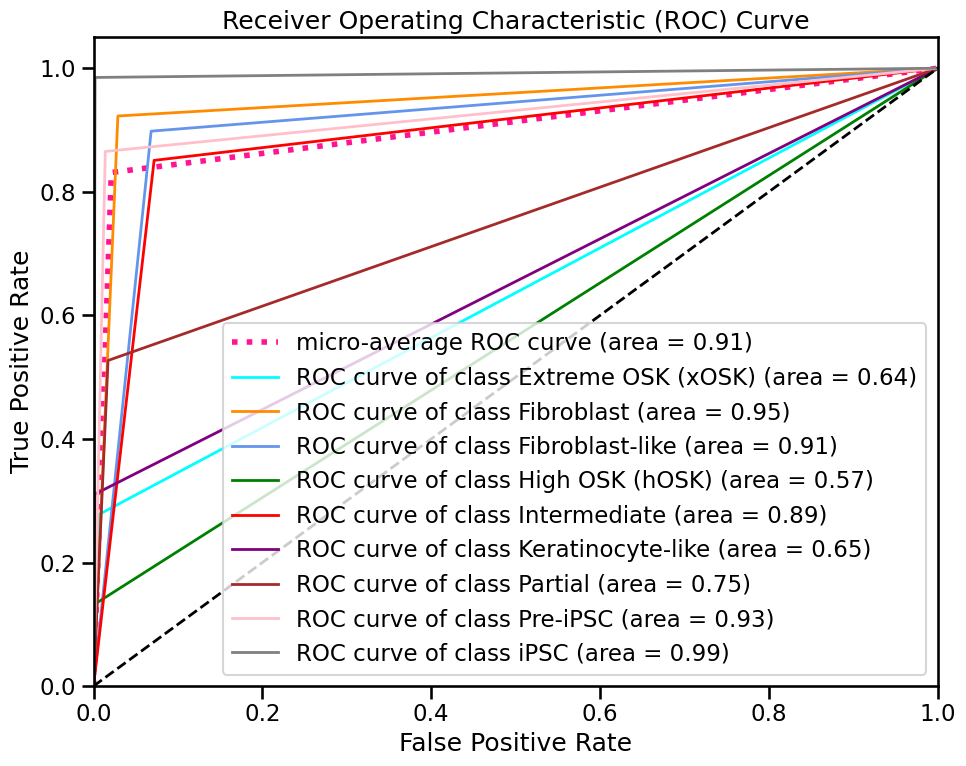

AUROC curve saved to 'auroc_curve.png'


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Get unique classes
classes = np.unique(gt)
n_classes = len(classes)

# Binarize the output
y_test = label_binarize(gt, classes=classes)

# Get predicted probabilities
y_score = np.zeros((len(preds), n_classes))
for i, pred in enumerate(preds):
    y_score[i, list(classes).index(pred)] = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Adjust layout to prevent cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Optionally, save the figure
plt.savefig('auroc_curve.png', dpi=300, bbox_inches='tight')
plt.close()

print("AUROC curve saved to 'auroc_curve.png'")

In [51]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
import pandas as pd

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(gt, preds, average=None)

# Get unique classes
classes = np.unique(gt)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Sort by F1 Score in descending order
metrics_df = metrics_df.sort_values('F1 Score', ascending=False)

# Add a row for weighted average
weighted_avg = precision_recall_fscore_support(gt, preds, average='weighted')
weighted_row = pd.DataFrame({
    'Class': ['Weighted Avg'],
    'Precision': [weighted_avg[0]],
    'Recall': [weighted_avg[1]],
    'F1 Score': [weighted_avg[2]]
})
metrics_df = pd.concat([metrics_df, weighted_row])

# Format float values to 3 decimal places
float_cols = ['Precision', 'Recall', 'F1 Score']
metrics_df[float_cols] = metrics_df[float_cols].applymap('{:.3f}'.format)

# Display the table
print(metrics_df.to_string(index=False))

# Optionally, save to CSV
metrics_df.to_csv('classification_metrics.csv', index=False)
print("\nMetrics saved to 'classification_metrics.csv'")

# Display classification report for additional metrics
print("\nClassification Report:")
print(classification_report(gt, preds))

             Class Precision Recall F1 Score
              iPSC     0.968  0.985    0.976
        Fibroblast     0.880  0.923    0.901
          Pre-iPSC     0.911  0.865    0.888
   Fibroblast-like     0.840  0.898    0.868
      Intermediate     0.755  0.851    0.800
           Partial     0.713  0.527    0.606
 Keratinocyte-like     0.757  0.311    0.441
Extreme OSK (xOSK)     0.582  0.277    0.376
   High OSK (hOSK)     0.304  0.134    0.186
      Weighted Avg     0.824  0.831    0.822

Metrics saved to 'classification_metrics.csv'

Classification Report:
                    precision    recall  f1-score   support

Extreme OSK (xOSK)       0.58      0.28      0.38       512
        Fibroblast       0.88      0.92      0.90      3312
   Fibroblast-like       0.84      0.90      0.87      5075
   High OSK (hOSK)       0.30      0.13      0.19       157
      Intermediate       0.76      0.85      0.80      3681
 Keratinocyte-like       0.76      0.31      0.44       280
           Pa

# FINAL RESULTS

# METRICS

In [67]:

# Calculate metrics
metrics = calculate_metrics(annotated_test_embed_adata, true_label_key, pred_key)

# Print results
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


ARI: 0.6755
NMI: 0.6538
ASW_LABEL: 0.0239
ASW_BATCH: -0.0021
accuracy: 0.8313
F1_SCORE: 0.8221


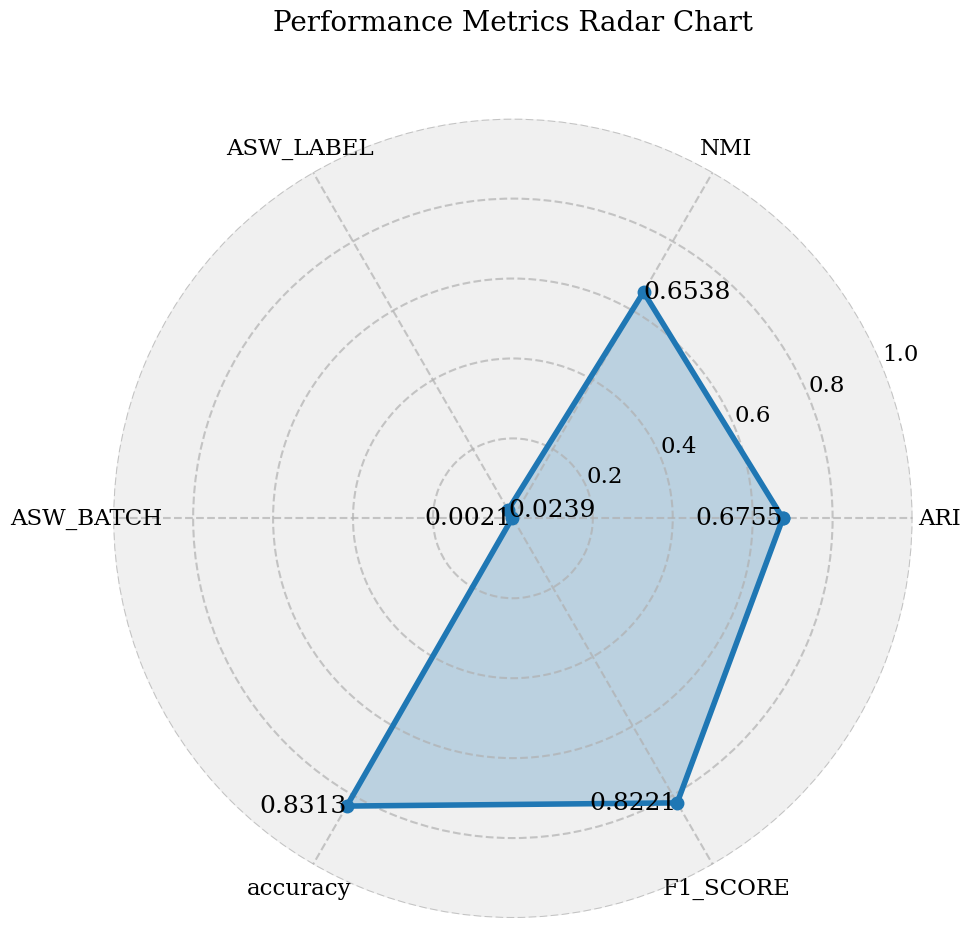

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def create_static_radar_chart(metrics):
    # Extract labels and values from the metrics dictionary
    labels = list(metrics.keys())
    values = list(metrics.values())

    # Number of variables
    num_vars = len(labels)

    # Split the circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Close the polygon by appending the start value to the end
    values += values[:1]
    angles += angles[:1]

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Draw the shape
    ax.plot(angles, values, 'o-', linewidth=4)
    ax.fill(angles, values, alpha=0.25)

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    # Set y-axis range
    ax.set_ylim(0, 1)

    # Add labels to the points
    for angle, value, label in zip(angles[:-1], values[:-1], labels):
        ha = 'left' if np.deg2rad(0) < angle < np.deg2rad(180) else 'right'
        ax.text(angle, value, f'{value:.4f}', ha=ha, va='center')

    # Add title
    plt.title("Performance Metrics Radar Chart", size=20, y=1.1)

    # Customize the chart
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['polar'].set_visible(False)
    ax.set_facecolor('#f0f0f0')

    # Improve aesthetics
    plt.tight_layout()

    # Save the plot as a high-quality PNG file
    plt.savefig('static_radar_chart.png', dpi=300, bbox_inches='tight')

    # Display the plot (optional, remove if you don't want to show it immediately)
    plt.show()

    # Close the plot to free up memory
    plt.close()

# Example usage:
metrics = {
    'ARI': 0.6755,
    'NMI': 0.6538,
    'ASW_LABEL': 0.0239,
    'ASW_BATCH': 0.0021,
    'accuracy': 0.8313,
    'F1_SCORE': 0.8221
}

create_static_radar_chart(metrics)

# AUROC

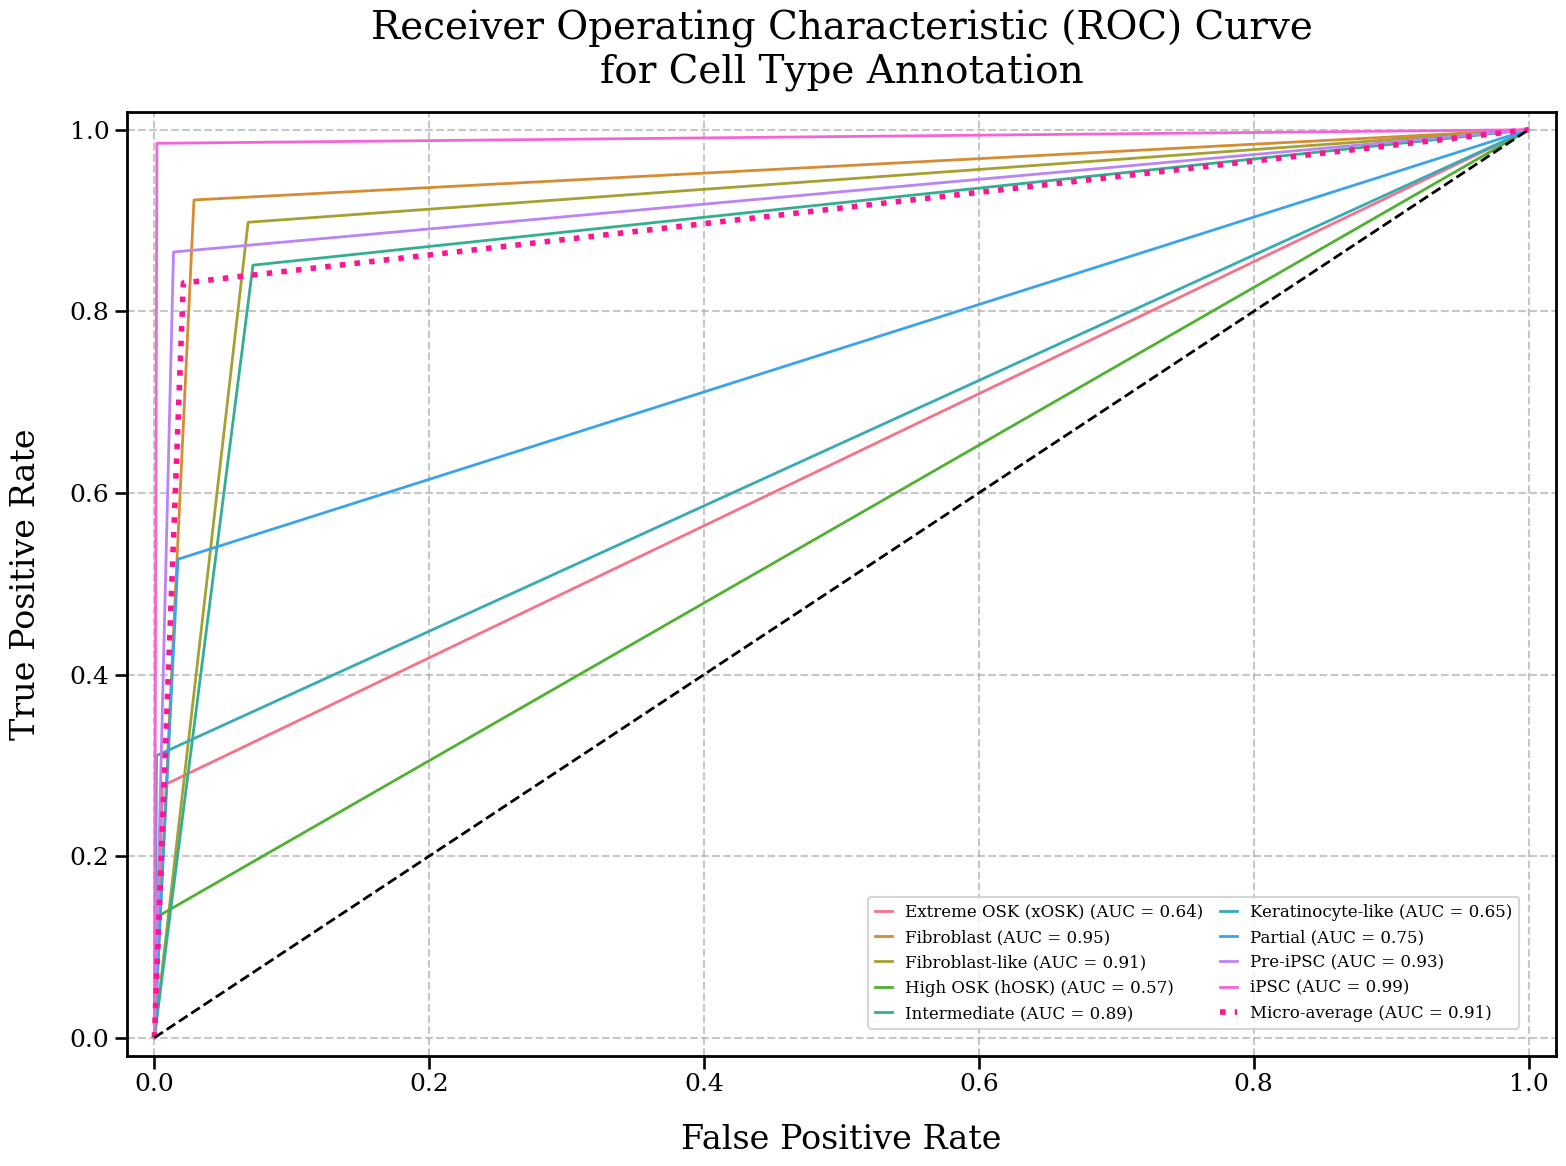

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import LabelEncoder

def plot_large_aesthetic_auroc_celltype(y_true, y_pred):
    # Get unique class names
    class_names = np.unique(np.concatenate((y_true, y_pred)))
    n_classes = len(class_names)

    # Encode labels
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred_encoded = le.transform(y_pred)

    # Binarize the output
    y_true_bin = label_binarize(y_true_encoded, classes=range(n_classes))
    y_pred_bin = label_binarize(y_pred_encoded, classes=range(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Set up the matplotlib figure
    plt.figure(figsize=(16, 12))

    # Use serif fonts for a more traditional scientific look
    plt.rcParams['font.family'] = 'serif'

    # Create custom color palette
    colors = sns.color_palette("husl", n_colors=n_classes)

    # Plot ROC curves
    lw = 2
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average (AUC = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)

    # Improve the aesthetics
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=24, labelpad=20)
    plt.ylabel('True Positive Rate', fontsize=24, labelpad=20)
    plt.title('Receiver Operating Characteristic (ROC) Curve\nfor Cell Type Annotation', fontsize=28, pad=20)

    # Adjust legend - place inside the plot
    plt.legend(loc="lower right", fontsize=12, bbox_to_anchor=(0.98, 0.02), 
               ncol=2, handlelength=1, columnspacing=1)

    # Add a border to the plot
    ax = plt.gca()
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)

    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Increase tick label font size
    plt.tick_params(axis='both', which='major', labelsize=18)

    # Adjust layout
    plt.tight_layout()

    # Save the plot with a larger DPI for better quality
    plt.savefig('large_aesthetic_auroc_curve_celltype.png', dpi=300, bbox_inches='tight')
    
    # Display the plot (optional, remove if you don't want to show it immediately)
    plt.show()
    
    # Close the plot to free up memory
    plt.close()

# Example usage:
plot_large_aesthetic_auroc_celltype(annotated_test_embed_adata.obs['celltype_gt'], 
                                     annotated_test_embed_adata.obs['celltype'])

# CONFUSION MATRIX

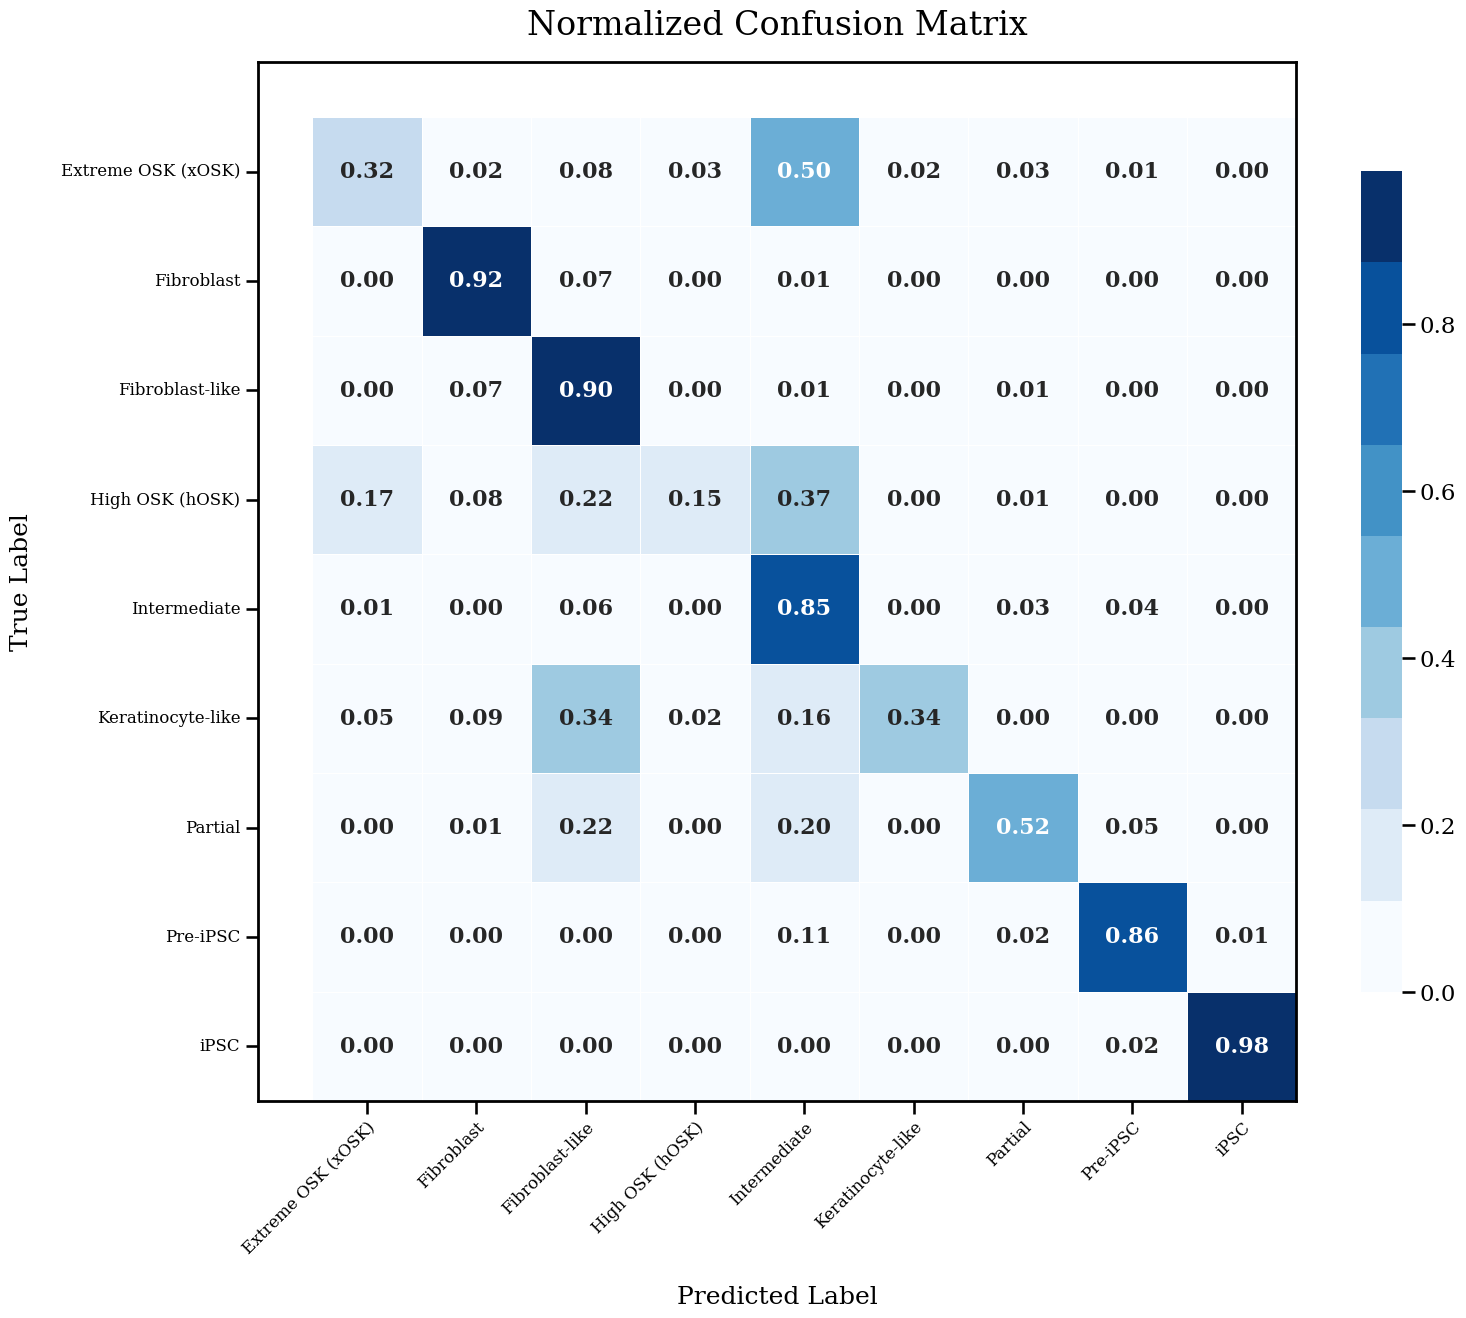

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def plot_aesthetic_normalized_confusion_matrix(y_true, y_pred):
    # Ensure labels are encoded as integers
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred_encoded = le.transform(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred_encoded)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Set up the matplotlib figure
    plt.figure(figsize=(16, 14))

    # Create a custom colormap
    colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
    cmap = sns.color_palette(colors, as_cmap=True)

    # Plot the heatmap
    ax = sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cmap, 
                     square=True, linewidths=0.5, cbar_kws={"shrink": .7},
                     annot_kws={'size': 16, 'weight': 'bold'}, 
                     xticklabels=le.classes_, yticklabels=le.classes_)

    # Improve the aesthetics
    plt.title('Normalized Confusion Matrix', fontsize=24, pad=20)
    plt.ylabel('True Label', fontsize=18, labelpad=20)
    plt.xlabel('Predicted Label', fontsize=18, labelpad=20)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, fontsize=22, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=22)

    # Increase tick label font size
    ax.tick_params(labelsize=12)

    # Add a border to the heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)

    # Use serif fonts for a more traditional scientific look
    plt.rcParams['font.family'] = 'serif'

    # Add gridlines
    ax.set_xticks(np.arange(cm_normalized.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm_normalized.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    plt.savefig('aesthetic_normalized_confusion_matrix.png', dpi=300, bbox_inches='tight')
    
    # Display the plot (optional, remove if you don't want to show it immediately)
    plt.show()
    
    # Close the plot to free up memory
    plt.close()

# Assuming 'gt' contains ground truth labels and 'preds' contains predicted labels
# Plot the aesthetic normalized confusion matrix
plot_aesthetic_normalized_confusion_matrix(annotated_test_embed_adata.obs['celltype_gt'], 
                                     annotated_test_embed_adata.obs['celltype'])

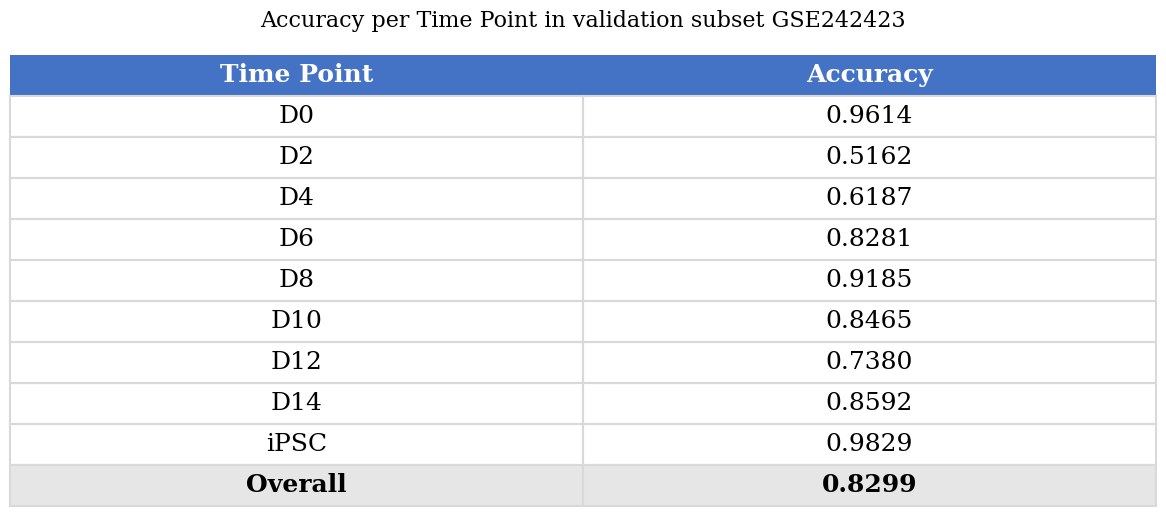

Table displayed


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

def create_accuracy_per_timepoint_table(adata, output_file='accuracy_per_timepoint.png'):
    # Extract the necessary information
    sample = adata.obs['sample']
    celltype_gt = adata.obs['celltype_gt']
    celltype_pred = adata.obs['celltype']
    
    # Define the order of time points
    time_point_order = ['D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D12', 'D14', 'iPSC']
    
    # Calculate accuracy per time point
    accuracy_per_timepoint = []
    for timepoint in time_point_order:
        if timepoint in sample.unique():
            mask = sample == timepoint
            accuracy = (celltype_gt[mask] == celltype_pred[mask]).mean()
            accuracy_per_timepoint.append({'Time Point': timepoint, 'Accuracy': accuracy})
    
    # Calculate overall accuracy
    overall_accuracy = (celltype_gt == celltype_pred).mean()
    accuracy_per_timepoint.append({'Time Point': 'Overall', 'Accuracy': overall_accuracy})
    
    # Create a DataFrame
    df = pd.DataFrame(accuracy_per_timepoint)
    df['Accuracy'] = df['Accuracy'].apply(lambda x: f'{x:.4f}')
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, (len(df)+1) * 0.5))
    ax.axis('off')
    
    # Create the table
    table = Table(ax, bbox=[0, 0, 1, 1])
    
    # Add cells
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    # Add header
    for col, header in enumerate(df.columns):
        cell = table.add_cell(0, col, width=0.5, height=0.1, text=header, 
                              loc='center', facecolor='#4472C4', edgecolor='none')
        cell.get_text().set_color('white')
        cell.get_text().set_fontweight('bold')
    
    # Add data
    for row, (_, row_data) in enumerate(df.iterrows(), start=1):
        for col, (_, value) in enumerate(row_data.items()):
            cell = table.add_cell(row, col, width=0.5, height=0.1, text=str(value), 
                                  loc='center', facecolor='none', edgecolor='#D9D9D9')
            if row == len(df):  # If it's the last row (Overall)
                cell.set_facecolor('#E6E6E6')
                cell.get_text().set_fontweight('bold')
    
    # Add the table to the plot
    ax.add_table(table)
    
    # Add a title
    plt.title('Accuracy per Time Point in validation subset GSE242423', fontsize=16, pad=20)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.show()
    #plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Table displayed")

# Example usage:
create_accuracy_per_timepoint_table(annotated_test_embed_adata)